In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import yfinance as yf
import pennylane as qml
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Quantum device setup with more qubits
dev = qml.device("default.qubit", wires=4)

In [3]:
# Modified quantum circuit
@qml.qnode(dev, interface='torch', diff_method='backprop')
def quantum_circuit(inputs, weights):
    """Quantum circuit for encoding and entanglement."""
    qml.AngleEmbedding(inputs, wires=range(4), rotation='X')
    qml.BasicEntanglerLayers(weights, wires=range(4))
    return [qml.expval(qml.PauliZ(i)) for i in range(4)]

In [4]:
# Quantum Layer
class QuantumLayer(nn.Module):
    def __init__(self, n_layers):
        super().__init__()
        weight_shapes = {"weights": (n_layers, 4)}
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

    def forward(self, x):
        return self.qlayer(x)

In [5]:
# Download BTC-USD data with additional features
data = yf.download('BTC-USD', start='2020-01-01', end='2024-01-01')
data['MA7'] = data['Close'].rolling(window=7).mean()
data['Volatility'] = data['Close'].rolling(window=7).std()
data = data[['Close', 'Volume', 'MA7', 'Volatility']]
data.dropna(inplace=True)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


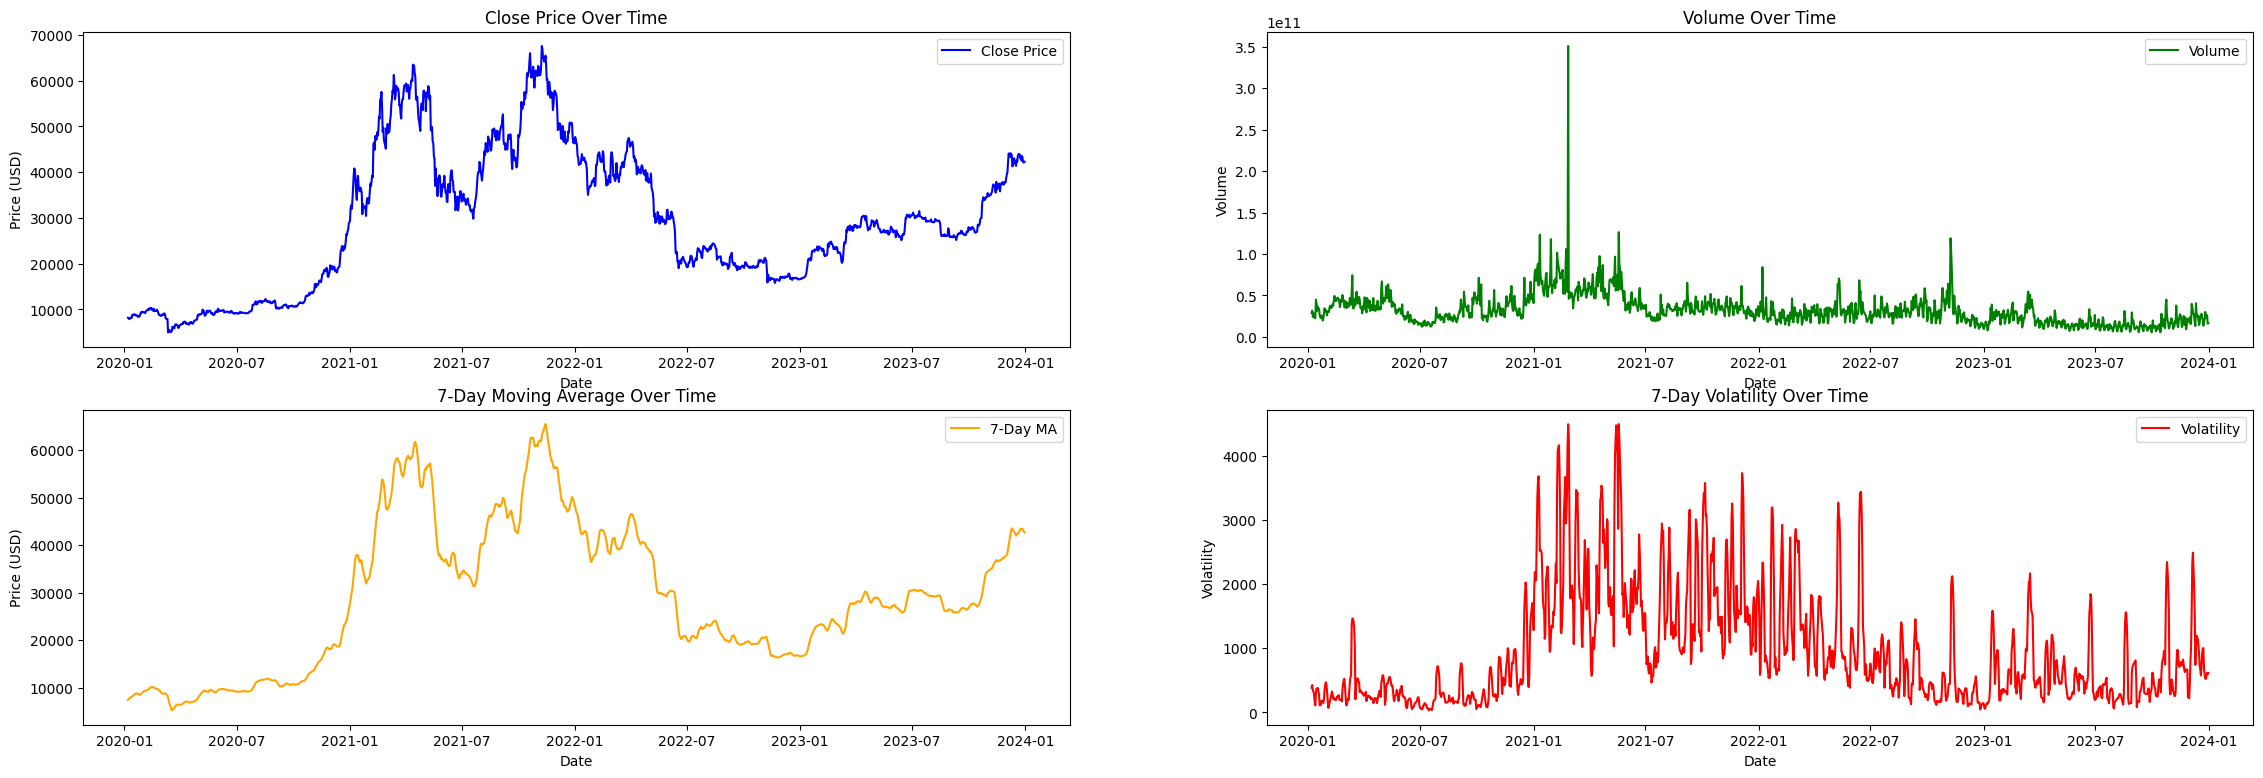

In [6]:
# Visualization 1: Feature Trends Plot
plt.figure(figsize=(28, 9))
plt.subplot(2, 2, 1)
plt.plot(data.index, data['Close'], label='Close Price', color='blue')
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(data.index, data['Volume'], label='Volume', color='green')
plt.title('Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(data.index, data['MA7'], label='7-Day MA', color='orange')
plt.title('7-Day Moving Average Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(data.index, data['Volatility'], label='Volatility', color='red')
plt.title('7-Day Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()

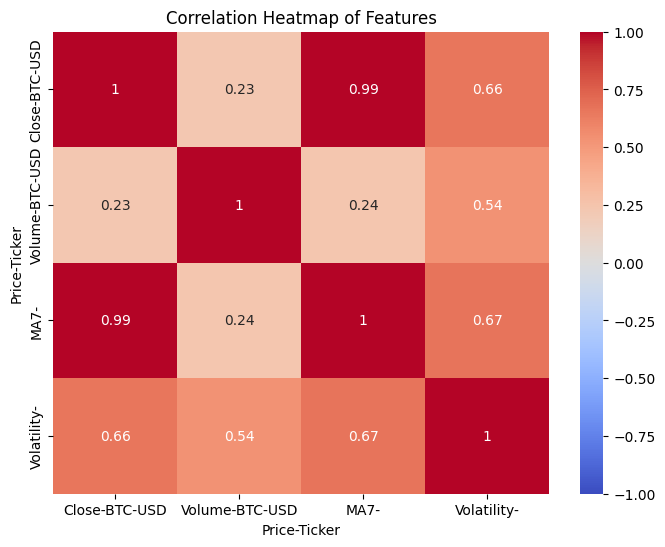

In [7]:
# Visualization 2: Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Features')
plt.show()

In [8]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data)

In [9]:
# Function to create sequences with multiple features
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

SEQ_LENGTH = 60
X, y = create_sequences(data_scaled, SEQ_LENGTH)

In [10]:
# Train-test split
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

In [11]:
#Enhanced Hybrid Quantum-Classical Model
class HybridCryptoModel(nn.Module):
    def __init__(self, input_features):
        super().__init__()
        self.fc1 = nn.Linear(SEQ_LENGTH * input_features, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, 4)
        self.q_layer = QuantumLayer(n_layers=4)
        self.fc4 = nn.Linear(4, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = self.q_layer(x)
        x = self.fc4(x)
        return x


In [12]:
# Initialize model, loss function, and optimizer
input_features = data.shape[1]
model = HybridCryptoModel(input_features=input_features)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [13]:
# Convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [14]:
# Train model with batch processing
losses = []
epochs = 100
batch_size = 32
for epoch in range(epochs):
    epoch_loss = 0
    for i in range(0, len(X_train_tensor), batch_size):
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    scheduler.step()
    avg_loss = epoch_loss / (len(X_train_tensor) / batch_size)
    losses.append(avg_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs} | Average Loss: {avg_loss:.6f}")

Epoch 0/100 | Average Loss: 0.119714
Epoch 10/100 | Average Loss: 0.037715
Epoch 20/100 | Average Loss: 0.012767
Epoch 30/100 | Average Loss: 0.010586
Epoch 40/100 | Average Loss: 0.009134
Epoch 50/100 | Average Loss: 0.009002
Epoch 60/100 | Average Loss: 0.008861
Epoch 70/100 | Average Loss: 0.008846
Epoch 80/100 | Average Loss: 0.008831
Epoch 90/100 | Average Loss: 0.008829


In [15]:
# Predict
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_tensor).numpy()
    # Debug: Check scaled predictions
    print("Sample scaled predictions:", y_pred_scaled[:5].flatten())

Sample scaled predictions: [0.39761138 0.3988489  0.39844888 0.40121883 0.40616488]


In [16]:
# Inverse transform predictions and actual values
y_pred_dummy = np.zeros((len(y_pred_scaled), data.shape[1]))
y_pred_dummy[:, 0] = y_pred_scaled[:, 0]
y_pred = scaler.inverse_transform(y_pred_dummy)[:, 0]

y_test_dummy = np.zeros((len(y_test), data.shape[1]))
y_test_dummy[:, 0] = y_test
y_test = scaler.inverse_transform(y_test_dummy)[:, 0]

In [17]:
# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f} USD")
print(f"Mean Squared Error (MSE): {mse:.2f} USD^2")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} USD")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 2617.32 USD
Mean Squared Error (MSE): 9284122.61 USD^2
Root Mean Squared Error (RMSE): 3046.99 USD
R² Score: 0.6582


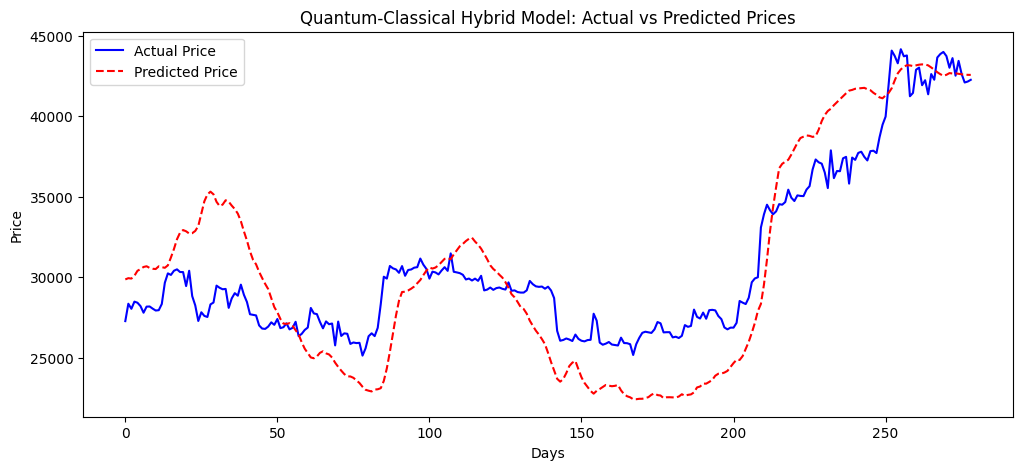

In [18]:
# Visualization 3: Actual vs Predicted Prices
plt.figure(figsize=(12, 5))
plt.plot(y_test, label='Actual Price', color='blue')
plt.plot(y_pred, label='Predicted Price', color='red', linestyle='dashed')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Quantum-Classical Hybrid Model: Actual vs Predicted Prices')
plt.show()

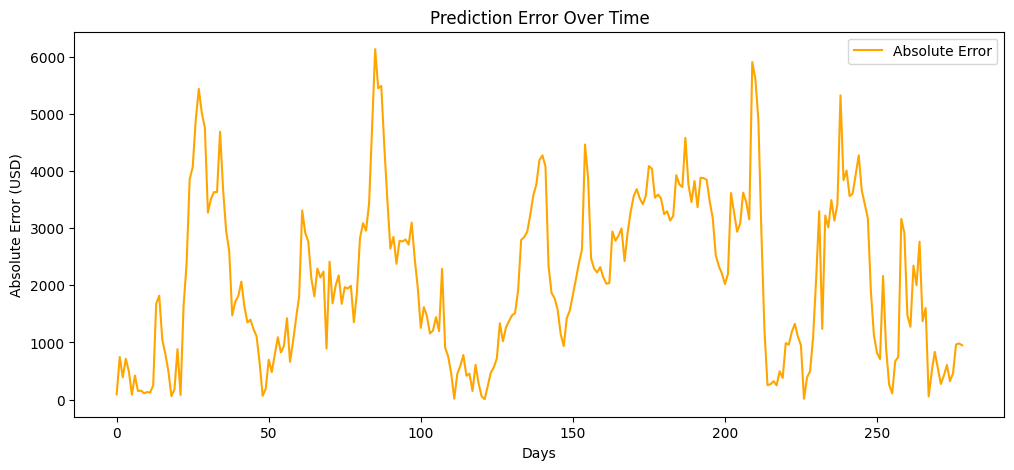

In [34]:
# Visualization 4: Prediction Error Plot
errors = np.abs(y_test - y_pred)
plt.figure(figsize=(12, 5))
plt.plot(errors, label='Absolute Error', color='orange')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Absolute Error (USD)')
plt.title('Prediction Error Over Time')
plt.show()

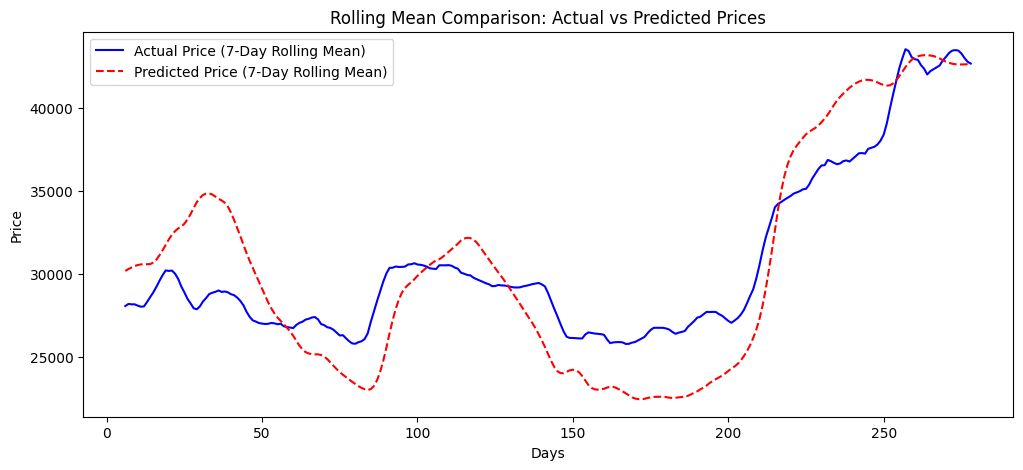

In [19]:
# Visualization 5: Rolling Mean Comparison
window = 7
actual_rolling = pd.Series(y_test).rolling(window=window).mean()
predicted_rolling = pd.Series(y_pred).rolling(window=window).mean()
plt.figure(figsize=(12, 5))
plt.plot(actual_rolling, label='Actual Price (7-Day Rolling Mean)', color='blue')
plt.plot(predicted_rolling, label='Predicted Price (7-Day Rolling Mean)', color='red', linestyle='dashed')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Rolling Mean Comparison: Actual vs Predicted Prices')
plt.show()

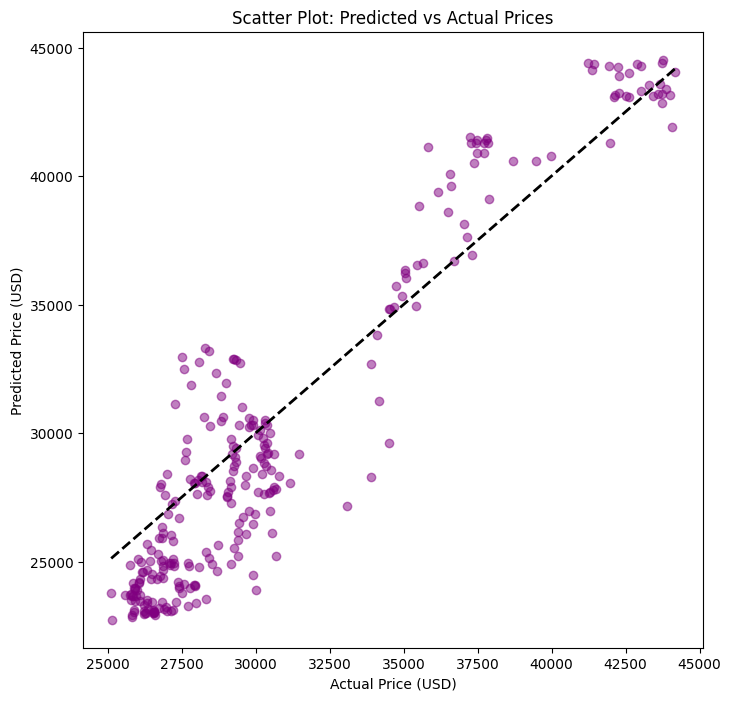

C:\Users\ADi\AppData\Local\Temp\ipykernel_3152\2881510713.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


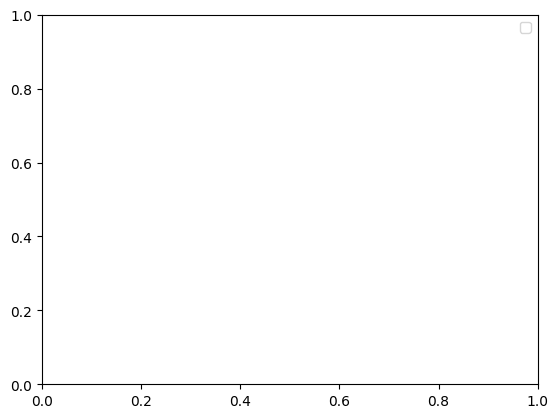

In [41]:

# Visualization 6: Prediction vs Actual Scatter Plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Price (USD)')
plt.ylabel('Predicted Price (USD)')
plt.title('Scatter Plot: Predicted vs Actual Prices')
plt.show()




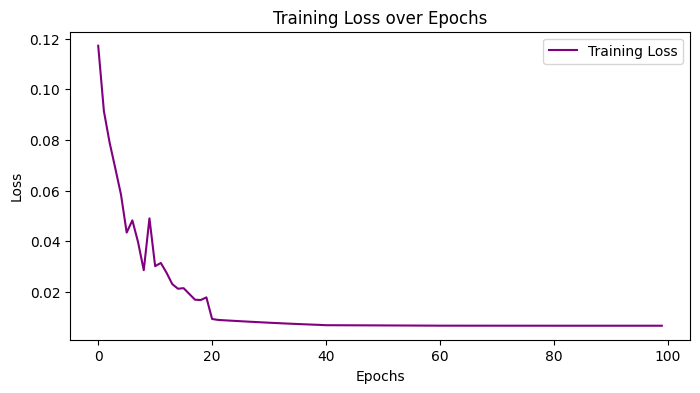

In [37]:
# Visualization 7: Training Loss
plt.figure(figsize=(8, 4))
plt.plot(losses, label='Training Loss', color='purple')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

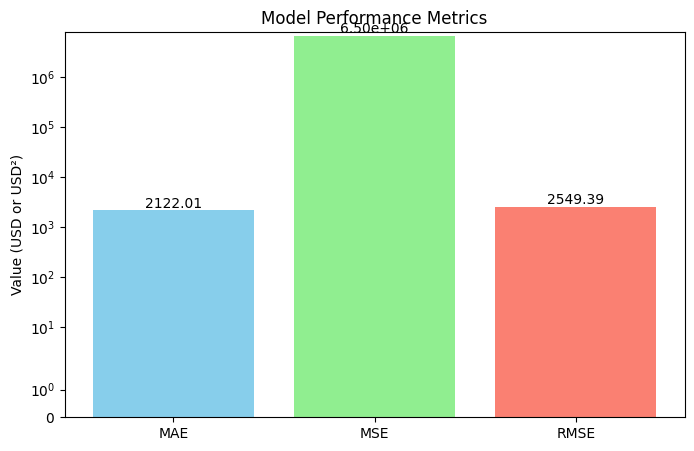

In [38]:
# Visualization 8: Metrics Bar Plot (MAE, MSE, RMSE) - Corrected
metrics = {'MAE': mae, 'MSE': mse, 'RMSE': rmse}
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(metrics.keys(), metrics.values(), color=['skyblue', 'lightgreen', 'salmon'])
ax.set_title('Model Performance Metrics')
ax.set_ylabel('Value (USD or USD²)')
for bar, val in zip(bars, metrics.values()):
    height = bar.get_height()
    if val == mse:
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{val:.2e}', ha='center', va='bottom')
    else:
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{val:.2f}', ha='center', va='bottom')
ax.set_yscale('symlog')  # Symmetric log scale to handle large MSE
ax.set_ylim(bottom=0, top=max(metrics.values()) * 1.2)
plt.show()

In [ ]:
# Visualization 9: R² Score Display

plt.figure(figsize=(6, 4))
plt.text(0.5, 0.5, f'R² Score: {r2:.4f}', fontsize=20, ha='center', va='center')
plt.axis('off')
plt.title('R² Score of the Model')
plt.show()

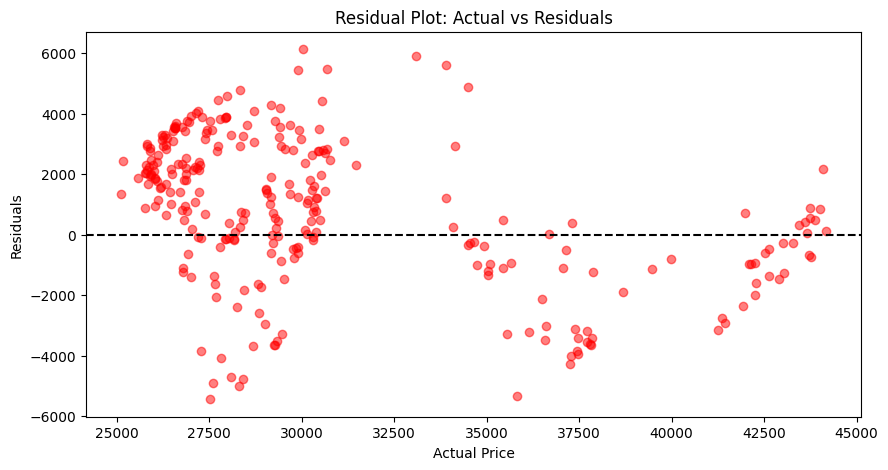

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming y_test and y_pred are already defined

# 1. Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals, alpha=0.5, color='red')
plt.axhline(0, linestyle='dashed', color='black')
plt.xlabel("Actual Price")
plt.ylabel("Residuals")
plt.title("Residual Plot: Actual vs Residuals")
plt.show()



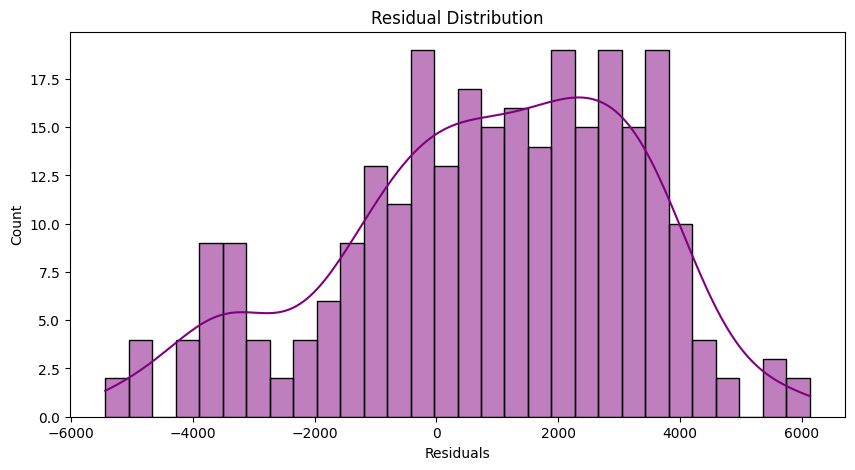

In [44]:
# 2. Residual Histogram
plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=30, kde=True, color="purple")
plt.xlabel("Residuals")
plt.title("Residual Distribution")
plt.show()




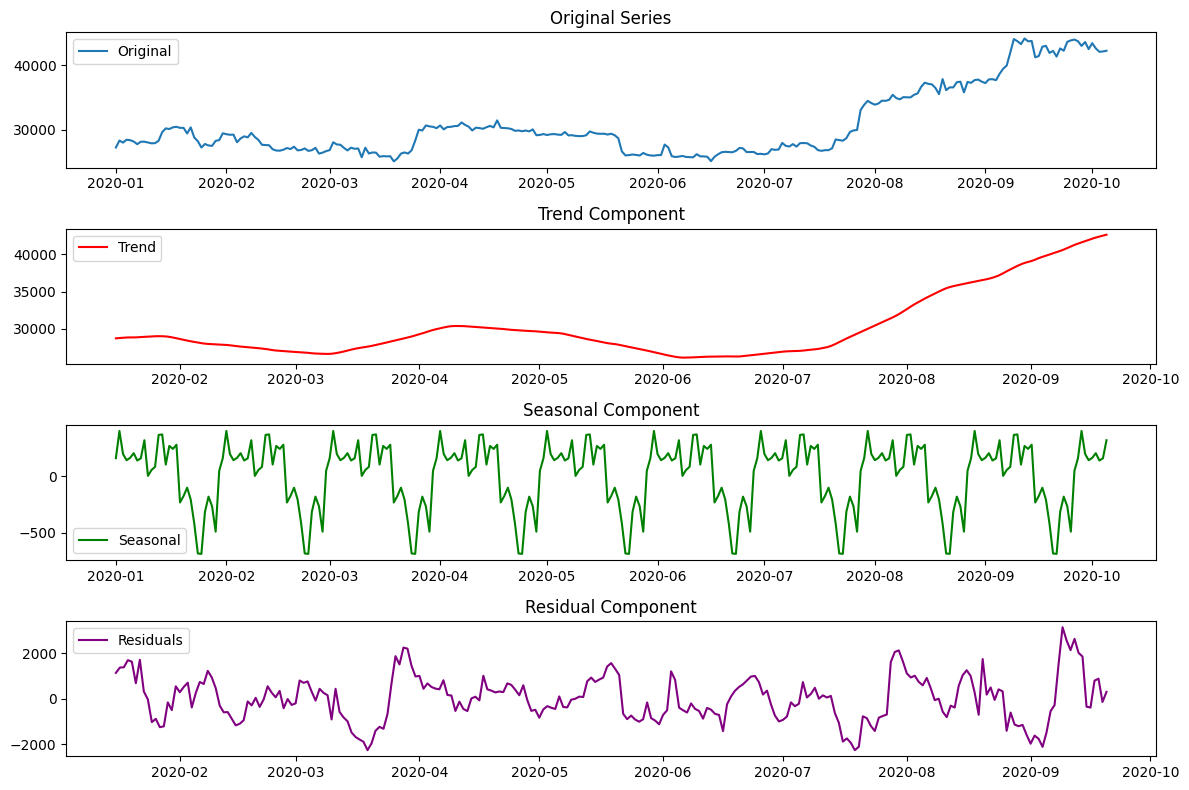

In [45]:
# 3. Trend Decomposition
series = pd.Series(y_test, index=pd.date_range(start="2020-01-01", periods=len(y_test)))
decomposed = seasonal_decompose(series, model='additive', period=30)
fig, ax = plt.subplots(4, 1, figsize=(12, 8))
ax[0].plot(series, label="Original")
ax[0].set_title("Original Series")
ax[1].plot(decomposed.trend, label="Trend", color="red")
ax[1].set_title("Trend Component")
ax[2].plot(decomposed.seasonal, label="Seasonal", color="green")
ax[2].set_title("Seasonal Component")
ax[3].plot(decomposed.resid, label="Residuals", color="purple")
ax[3].set_title("Residual Component")
for a in ax:
    a.legend()
plt.tight_layout()
plt.show()



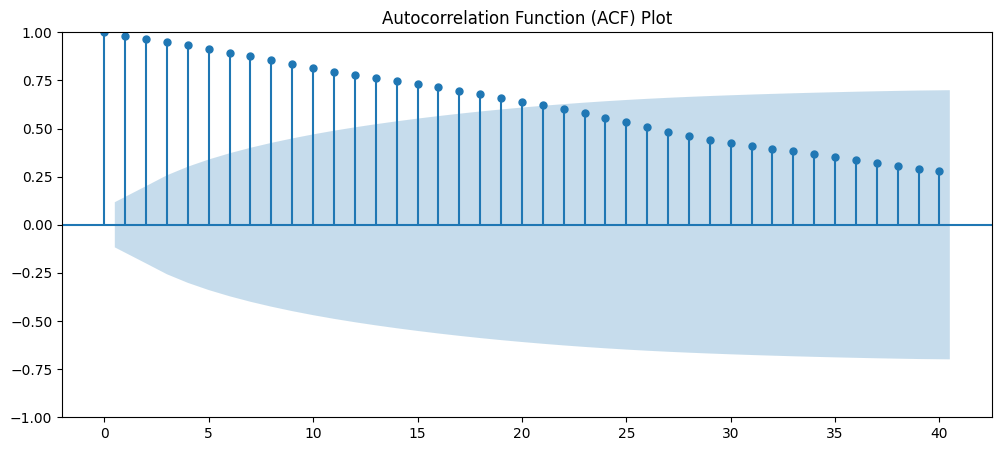

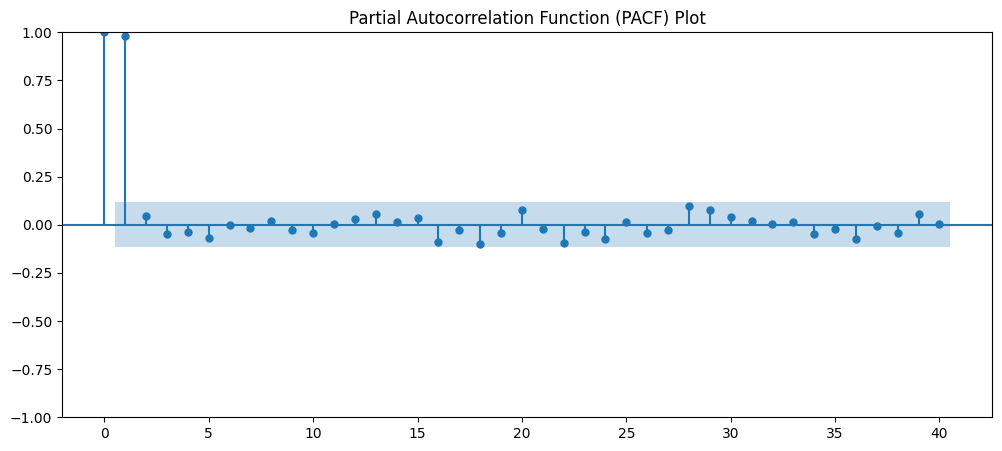

In [47]:
# 4. Autocorrelation Function (ACF)
fig, ax = plt.subplots(figsize=(12, 5))
sm.graphics.tsa.plot_acf(y_test, lags=40, ax=ax)
plt.title("Autocorrelation Function (ACF) Plot")
plt.show()

# 5. Partial Autocorrelation Function (PACF)
fig, ax = plt.subplots(figsize=(12, 5))
sm.graphics.tsa.plot_pacf(y_test, lags=40, ax=ax)
plt.title("Partial Autocorrelation Function (PACF) Plot")
plt.show()